- PCA itu untuk menemukan arah varian dan varian diukur dari titik pusat atau rata rata
- Memusatkan data dengan menghitung rata-rata setiap kolom pixel x lalu dikurangi setiap elemen dengan nilai rata rata untuk mendapatkan nilai yang terpusat.
- Hitung matriks kovarians dari matriks x. jadi cari C dari Xc dengan rumusnya (rumus ppt)
- untuk eigenvektor itu untuk memberi arah dari sumbu baru data dan eigenvalue itu menghasilkan nilai yang penting dari eigenvektor. Semakin besar berarti varian data banyak
- Urutkan pasangan eigenvektor dan eigenvalue dari terbesar hingga terkecil dan ambil eigenvektor sesuai k yang diinginkan. Misal k=25 berarti ambil 25 teratas
- Jumlahkan eigenvektor yang mana nantinya jadi sebuah matriks proyeksi
- Kalikan matriks data terpusat dengan matrik proyeksi untuk representasi gambar

- SVD
- ....




In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load gambar dan konversi ke array float
img = plt.imread('img/gregeddd.jpg')
if img.ndim == 3:
    img = img.mean(axis=2)
img = img.astype(np.float32)
k = 25

# PCA manual
X = img.copy()
X_mean = np.mean(X, axis=0)
X_terpusat = X - X_mean

# Matriks kovarians (Cov(X) = (X^T X) / (n-1))
cov = (X_terpusat.T @ X_terpusat) / (X_terpusat.shape[0] - 1)

# Eigenvalue dan eigenvector (Cov X = V Λ V^T)
eigval, eigvec = np.linalg.eigh(cov)
idx = np.argsort(eigval)[::-1] # Urutkan menurun
eigval = eigval[idx][:k] # Ambil k terbesar
eigvec = eigvec[:, idx][:, :k] # Ambil k eigenvector utama

# PCA (Z = X_terpusat @ V_k)
fitur_pca = X_terpusat @ eigvec

# Rekonstruksi gambar (X_recon = Z @ V_k^T + mean)
X_recon = fitur_pca @ eigvec.T + X_mean #(terpusat)

# SVD
# SVD= X = U S V^T
AAT = X @ X.T # Untuk U dan S
ATA = X.T @ X

# Eigenvalue dan eigenvector (AAT = U Λ U^T, ATA = V Λ V^T)
eigval_U, U = np.linalg.eigh(AAT)
eigval_V, V = np.linalg.eigh(ATA)

eigval_U = np.clip(eigval_U, 0, None) 
eigval_V = np.clip(eigval_V, 0, None)

# Singular value (S = sqrt(eigenvalue_U), ambil k terbesar)
S = np.sqrt(np.sort(eigval_U)[::-1])[:k] 
U = U[:, np.argsort(eigval_U)[::-1][:k]]
V = V[:, np.argsort(eigval_V)[::-1][:k]]

# gambar SVD (X ≈ U_k S_k V_k^T)
fitur_svd = U * S
recon_svd = (U * S) @ V.T

# Hu Moments
# Raw moment: m_pq = Σx Σy x^p y^q f(x,y)
def raw_moment(arr, p, q):
    y, x = np.indices(arr.shape)
    return np.sum((x**p) * (y**q) * arr)

# Central moment: μ_pq = Σx Σy (x-x̄)^p (y-ȳ)^q f(x,y)
def central_moment(arr, p, q):
    y, x = np.indices(arr.shape)
    m00 = raw_moment(arr, 0, 0)
    x_bar = raw_moment(arr, 1, 0) / m00
    y_bar = raw_moment(arr, 0, 1) / m00
    return np.sum(((x - x_bar)**p) * ((y - y_bar)**q) * arr)

# 7 invariant moments dari kombinasi momen normalisasi
def hu_moments(arr):
    arr = np.clip(arr, 0, 255)
    m00 = raw_moment(arr, 0, 0)
    m10 = raw_moment(arr, 1, 0)
    m01 = raw_moment(arr, 0, 1)
    x_bar = m10 / m00
    y_bar = m01 / m00

    mu20 = central_moment(arr, 2, 0)
    mu02 = central_moment(arr, 0, 2)
    mu11 = central_moment(arr, 1, 1)
    mu30 = central_moment(arr, 3, 0)
    mu03 = central_moment(arr, 0, 3)
    mu12 = central_moment(arr, 1, 2)
    mu21 = central_moment(arr, 2, 1)

    # Normalisasi momen (η_pq = μ_pq / m00^γ)
    eta20 = mu20 / m00**2
    eta02 = mu02 / m00**2
    eta11 = mu11 / m00**2
    eta30 = mu30 / m00**2.5
    eta03 = mu03 / m00**2.5
    eta12 = mu12 / m00**2.5
    eta21 = mu21 / m00**2.5

    # Rumus Hu Moments (7 invariant moments)
    hu = np.zeros(7)
    hu[0] = eta20 + eta02
    hu[1] = (eta20 - eta02)**2 + 4*eta11**2
    hu[2] = (eta30 - 3*eta12)**2 + (3*eta21 - eta03)**2
    hu[3] = (eta30 + eta12)**2 + (eta21 + eta03)**2
    hu[4] = (eta30 - 3*eta12)*(eta30 + eta12)*((eta30 + eta12)**2 - 3*(eta21 + eta03)**2) + \
            (3*eta21 - eta03)*(eta21 + eta03)*(3*(eta30 + eta12)**2 - (eta21 + eta03)**2)
    hu[5] = (eta20 - eta02)*((eta30 + eta12)**2 - (eta21 + eta03)**2) + 4*eta11*(eta30 + eta12)*(eta21 + eta03)
    hu[6] = (3*eta21 - eta03)*(eta30 + eta12)*((eta30 + eta12)**2 - 3*(eta21 + eta03)**2) - \
            (eta30 - 3*eta12)*(eta21 + eta03)*(3*(eta30 + eta12)**2 - (eta21 + eta03)**2)
    return hu

hu_asli = hu_moments(img)
hu_pca = hu_moments(X_recon)
hu_svd = hu_moments(recon_svd)


print('EIGENVALUE PCA')
for i, val in enumerate(eigval):
    print(f'Komponen {i+1}: {val:.4f}')

print('\nSINGULAR VALUE SVD')
for i, val in enumerate(S):
    print(f'Komponen {i+1}: {val:.4f}')

print('\nNILAI HU MOMENT')
print('Gambar asli:')
for i, val in enumerate(hu_asli):
    print(f'  Hu[{i+1}]: {val:.6e}')
print('Gambar PCA:')
for i, val in enumerate(hu_pca):
    print(f'  Hu[{i+1}]: {val:.6e}')
print('Gambar SVD:')
for i, val in enumerate(hu_svd):
    print(f'  Hu[{i+1}]: {val:.6e}')



EIGENVALUE PCA
Komponen 1: 85248.0078
Komponen 2: 37148.3398
Komponen 3: 34008.2070
Komponen 4: 21159.3945
Komponen 5: 17662.7031
Komponen 6: 12566.5732
Komponen 7: 10794.9043
Komponen 8: 10529.0322
Komponen 9: 8634.2305
Komponen 10: 5618.7456
Komponen 11: 5004.1733
Komponen 12: 4283.8027
Komponen 13: 4114.9800
Komponen 14: 3564.3853
Komponen 15: 2849.6692
Komponen 16: 2377.5840
Komponen 17: 2277.1746
Komponen 18: 2043.8964
Komponen 19: 2015.2052
Komponen 20: 1628.5023
Komponen 21: 1539.5751
Komponen 22: 1383.4951
Komponen 23: 1356.6506
Komponen 24: 1215.1969
Komponen 25: 1064.1802

SINGULAR VALUE SVD
Komponen 1: 13576.1943
Komponen 2: 4218.7192
Komponen 3: 2825.4761
Komponen 4: 2184.4722
Komponen 5: 2002.5942
Komponen 6: 1681.5919
Komponen 7: 1583.9954
Komponen 8: 1545.4702
Komponen 9: 1400.6866
Komponen 10: 1284.2198
Komponen 11: 1068.8767
Komponen 12: 1016.9246
Komponen 13: 973.7109
Komponen 14: 895.7875
Komponen 15: 807.8926
Komponen 16: 732.4934
Komponen 17: 725.4627
Komponen 18: 

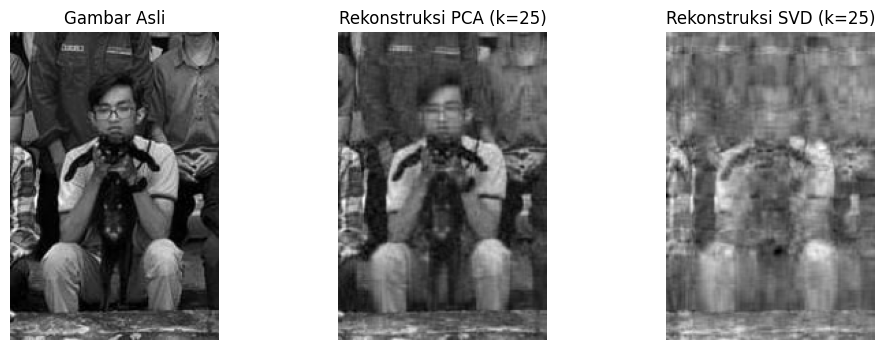

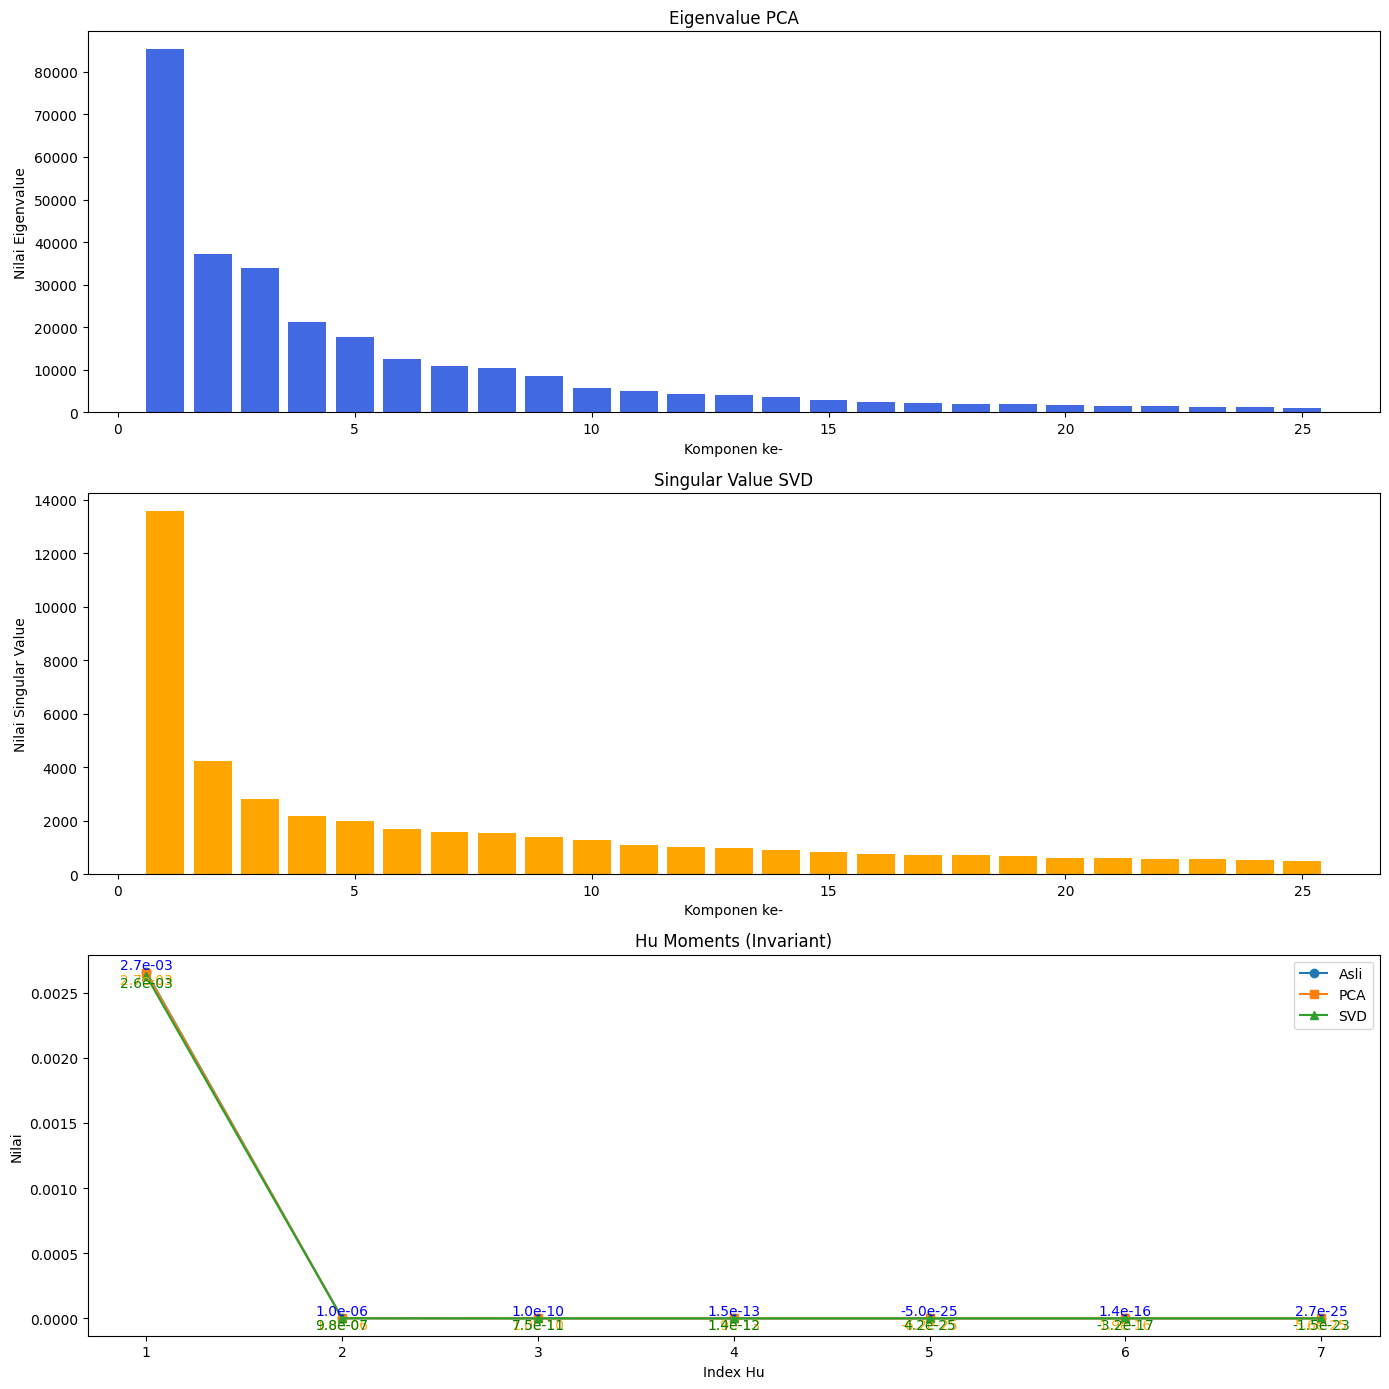

In [2]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('Gambar Asli')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(X_recon, cmap='gray')
plt.title(f'Rekonstruksi PCA (k={k})')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(recon_svd, cmap='gray')
plt.title(f'Rekonstruksi SVD (k={k})')
plt.axis('off')
plt.show()

plt.figure(figsize=(14,14))
plt.subplot(3,1,1)
plt.bar(range(1, k+1), eigval, color='royalblue')
plt.title('Eigenvalue PCA')
plt.xlabel('Komponen ke-')
plt.ylabel('Nilai Eigenvalue')

plt.subplot(3,1,2)
plt.bar(range(1, k+1), S, color='orange')
plt.title('Singular Value SVD')
plt.xlabel('Komponen ke-')
plt.ylabel('Nilai Singular Value')

plt.subplot(3,1,3)
plt.plot(range(1, 8), hu_asli, 'o-', label='Asli')
plt.plot(range(1, 8), hu_pca, 's-', label='PCA')
plt.plot(range(1, 8), hu_svd, '^-', label='SVD')
plt.title('Hu Moments (Invariant)')
plt.xlabel('Index Hu')
plt.ylabel('Nilai')
for i in range(7):
    plt.text(i+1, hu_asli[i], f"{hu_asli[i]:.1e}", fontsize=10, ha='center', va='bottom', color='blue')
    plt.text(i+1, hu_pca[i], f"{hu_pca[i]:.1e}", fontsize=10, ha='center', va='top', color='orange')
    plt.text(i+1, hu_svd[i], f"{hu_svd[i]:.1e}", fontsize=10, ha='center', va='top', color='green')
plt.legend()
plt.tight_layout()
plt.show()